In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
input_size = 28 * 28
num_digits = 10

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [4]:
params = {
    'encoder_layers': [128],                # the encoder will be implemented using a simple feed forward network
    'decoder_layers': [128],                # and so will the decoder (CNN will be better, but I want to keep the code simple)
    'digit_classification_layers': [128],   # this is for the conditioning. I'll explain it later on
    'activation': tf.nn.sigmoid,            # the activation function used by all sub-networks
    'decoder_std': 0.5,                     # the standard deviation of P(x|z) discussed in the previous post
    'z_dim': 10,                            # the dimension of the latent space
    'digit_classification_weight': 10.0,    # this is for the conditioning. I'll explain it later on
    'epochs': 20,
    'batch_size': 100,
    'learning_rate': 0.001
}

In [5]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits


In [6]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# encode an image into a distribution over the latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])

# sample a latent vector from the latent space - using the reparameterization trick
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
digit_logits = digit_classifier(images,
                                params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode the latent vector - concatenated to the digits classification - into an image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

In [7]:
# the loss is composed of how well we can reconstruct the image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# and how off the distribution over the latent space is from the prior.
# Given the prior is a standard Gaussian and the inferred distribution
# is a Gaussian with a diagonal covariance matrix, the KL-divergence
# becomes analytically solvable, and we get
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# digit_classification_weight is used to weight between the two losses,
# since there's a tension between them
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits,
                                                   logits=digit_logits),
    axis=0
)

loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [12]:
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        for _ in range(mnist.train.num_examples // params['batch_size']):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

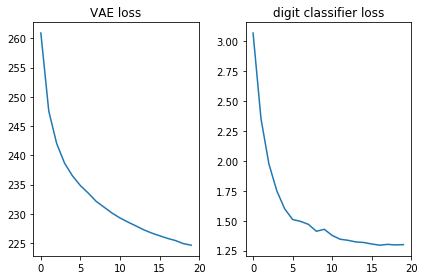

In [14]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('VAE loss')

plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('digit classifier loss')

plt.tight_layout()

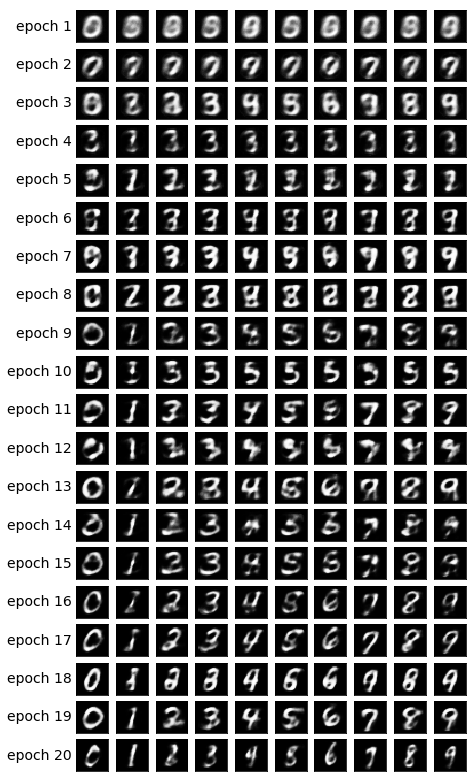

In [15]:
def plot_samples(samples):
    IMAGE_WIDTH = 0.7
    plt.figure(figsize=(IMAGE_WIDTH * num_digits,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_digits,
                        epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)